In [15]:
import numpy as np
import matplotlib.pyplot as plt


def readshd( filename=None, xs=None, ys=None ):
    #*******************************************************************************
    # Mexilhoeira Grande, Sex Jul 28 16:37:29 WEST 2017
    # Written by Tordar
    # Based on read_shd_bin.m by Michael Porter
    #*******************************************************************************
    
   fid = open(filename,'rb')
   recl  = int( np.fromfile( fid, np.int32, 1 ) )
   title = fid.read(80)
   fid.seek( 4*recl )
   PlotType = fid.read(10)
   fid.seek( 2*4*recl ); # reposition to end of second record
   Nfreq  = int(   np.fromfile( fid, np.int32  , 1 ) )
   Ntheta = int(   np.fromfile( fid, np.int32  , 1 ) )
   Nsx    = int(   np.fromfile( fid, np.int32  , 1 ) )
   Nsy    = int(   np.fromfile( fid, np.int32  , 1 ) )
   Nsd    = int(   np.fromfile( fid, np.int32  , 1 ) )
   Nrd    = int(   np.fromfile( fid, np.int32  , 1 ) )
   Nrr    = int(   np.fromfile( fid, np.int32  , 1 ) ) 
   atten  = float( np.fromfile( fid, np.float32, 1 ) )
   fid.seek( 3 * 4 * recl ); # reposition to end of record 3
   freqVec = np.fromfile( fid, np.float32, Nfreq  )
   fid.seek( 4 * 4 * recl ); # reposition to end of record 4
   thetas  = np.fromfile( fid, np.float32, Ntheta )
   if  ( PlotType[ 0 : 1 ] != 'TL' ):
       fid.seek( 5 * 4 * recl ); # reposition to end of record 4
       Xs     = np.fromfile( fid, np.float32, Nsx )
       fid.seek( 6 * 4 * recl );  # reposition to end of record 5
       Ys     = np.fromfile( fid, np.float32, Nsy )
   else:   # compressed format for TL from FIELD3D
       fid.seek( 5 * 4 * recl ); # reposition to end of record 4
       Pos_S_x     = np.fromfile( fid, np.float32, 2 )
       Xs          = np.linspace( Pos_S_x[0], Pos_S_x[1], Nsx )
       fid.seek( 6 * 4 * recl ); # reposition to end of record 5
       Pos_S_y     = np.fromfile( fid, np.float32, 2 )
       Ys          = np.linspace( Pos_S_y[0], Pos_S_y[1], Nsy )
   fid.seek( 7 * 4 * recl ) # reposition to end of record 6
   zs = np.fromfile( fid, np.float32, Nsd )
   fid.seek( 8 * 4 * recl ) # reposition to end of record 7
   zarray =  np.fromfile( fid, np.float32, Nrd )
   fid.seek( 9 * 4 * recl ) # reposition to end of record 8
   rarray =  np.fromfile( fid, np.float32, Nrr )
   if PlotType == 'rectilin  ':
       pressure = np.zeros( (Ntheta, Nsd, Nrd, Nrr) ) + 1j*np.zeros( (Ntheta, Nsd, Nrd, Nrr) )
       Nrcvrs_per_range = Nrd
   elif PlotType == 'irregular ':
       pressure = np.zeros( (Ntheta, Nsd,   1, Nrr) ) + 1j*np.zeros( (Ntheta, Nsd, Nrd, Nrr) )
       Nrcvrs_per_range = 1
   else:
       pressure = np.zeros( (Ntheta, Nsd, Nrd, Nrr) )
       Nrcvrs_per_range = Nrd
   pressure = np.zeros( (Ntheta,Nsd,Nrcvrs_per_range,Nrr) ) + 1j*np.zeros( (Ntheta,Nsd,Nrcvrs_per_range,Nrr) )
   if np.isnan( xs ):    
      for itheta in range(Ntheta):
          for isd in range( Nsd ):
              for ird in range( Nrcvrs_per_range ):
                  recnum = 10 + itheta * Nsd * Nrcvrs_per_range + isd * Nrcvrs_per_range + ird
                  status = fid.seek( recnum * 4 * recl ) # Move to end of previous record
                  if ( status == -1 ):
                     print ('Seek to specified record failed in readshd...')
                  temp = np.fromfile( fid, np.float32, 2 * Nrr ) # Read complex data
                  for k in range(Nrr):
                      pressure[ itheta, isd, ird, k ] = temp[ 2 * k ] + 1j * temp[ 2*k + 1 ]

   else:    
       xdiff = abs( Xs - xs * 1000.0 )
       idxX  = xdiff.argmin(0)
       ydiff = abs( Ys - ys * 1000.0 )
       idxY  = ydiff.argmin(0)
       for itheta in range(Ntheta):
           for isd in range(Nsd):
               for ird in range( Nrcvrs_per_range ):
                   recnum = 10 + idxX * Nsy * Ntheta * Nsd * Nrcvrs_per_range + idxY * Ntheta * Nsd * Nrcvrs_per_range + itheta * Nsd * Nrcvrs_per_range + isd * Nrcvrs_per_range + ird
                   status = fid.seek( recnum * 4 * recl ) # Move to end of previous record
                   if ( status == -1 ):
                      print ('Seek to specified record failed in read_shd_bin')
                   temp = np.fromfile( fid, np.float32, 2 * Nrr ) # Read complex data
                   for k in range(Nrr):
                       pressure[ itheta, isd, ird, k ] = temp[ 2 * k ] + 1j * temp[ 2*k + 1 ]
               
       fid.close()
   geometry = {"zs":zs, "f":freqVec,"thetas":thetas,"rarray":rarray,"zarray":zarray}
   return pressure,geometry


filename = 'cognac_2000m_SSP2.shd'
pressure, geometry = readshd(filename, np.NaN, np.NaN)

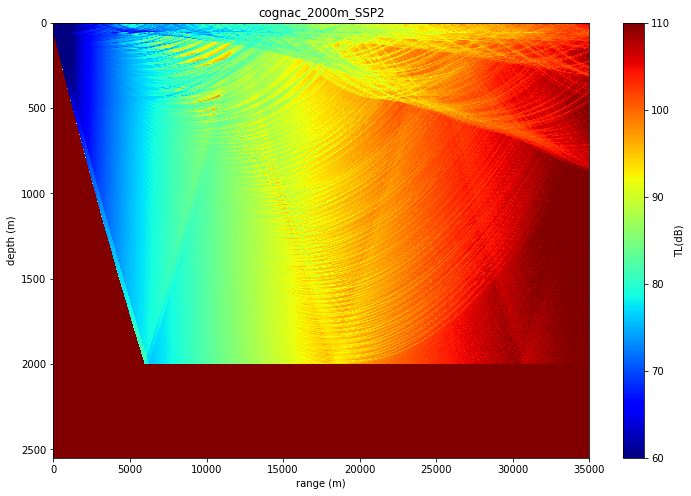

In [22]:
# range and depth
rt = geometry.get ("rarray")
zt = geometry.get ("zarray")

# pressure
P = np.squeeze(pressure).real
Pabs = abs(P)
Pabs[np.where(np.isnan(Pabs))] = 1e-6  #remove NaNs
Pabs[np.where(np.isinf(Pabs))] = 1e-6  #remove infinities
Pabs[np.where(Pabs<1e-37)] = 1e-37     #remove zeros


# transmission loss
TL = -20.0 * np.log10 (Pabs) 


#statistics to define limits of colorbar
icount = TL[np.where(Pabs > 1e-37)]       # statistics only on pressure P > 1e-37
tlmed = np.median (icount)                # median value
tlstd = np.std(icount)                    # standard deviation
tlmax = tlmed + 0.75 * tlstd              # max for colorbar
tlmax = 10 * np.round (tlmax/10)          # make sure the limits are round numbers
tlmin = tlmax - 50                        # min for colorbar

# plot TL 
plt.figure(figsize=(12,8))
plt.pcolormesh (rt, zt, TL, cmap='jet')
plt.title (filename[:-4])
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("TL(dB)")
plt.clim ([tlmin,tlmax])
plt.gca().invert_yaxis()

plt.savefig('plotshd_'+filename[:-4], dpi=100)
